# Goal: Experiment with Optimisation techniques using Knowledge Distillation ideas.

The objective is `never to start from scratch`, we have `2 backbones` of the same model blueprint. One is a `heavy backbone` and the other is `much lighter one`( say mobile_net backbone ).

Using these, `how to distill` the information captured by heavier model down to the lighter model with a `reasonable accuracy/information loss`? We are solving this problem.

Usual training:
  - On teacher: `pretrained`
  - On student: `pretrained`, but ...
Distillation training:
  - On teacher: No.
  - On student: We have to find a sweet-spot between,   
    - `hard-label` mimic i.e classification accuracy( as we
     distill weights from teacher )
    - mimicing the `soft-label` i.e imagine trying to `minimise distance` between `probabilty-distribution` between  
      `softmax distribution` of `teacher` and `softmax distribution` of `student`.
    )


* 5 Main Sections
  - ~Dataset for CityScapes for KD Experiment~
  - ~Teacher Model~
  - ~Student Model~
  - ~Knowledge DIstillation using Kuhlback-Leiber Divergence~
  - ~Results~


  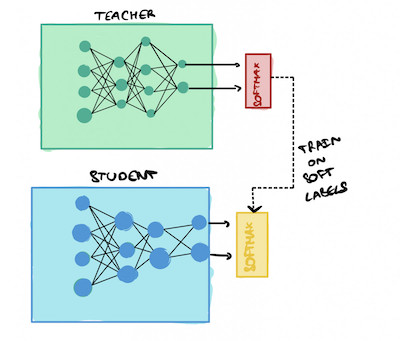

### Imports

In [ ]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/knowledge_distillation_content.zip && unzip -q knowledge_distillation_content.zip && rm knowledge_distillation_content.zip

In [ ]:
# Basic imports
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# DL imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

### Saving and loading the soft-labels from teacher model
  - Run the inference pipeline and save the soft-labels of the teacher model on each image as `.pt` file.
  - Load these in dataloader class and send when `__get_item()` is invoked.

In [ ]:
class CityScape_KD(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        # filter common files in 3 folders
        common_files = sorted(os.listdir(os.path.join(*['knowledge_distillation_content', 'semSeg_256_512','teacherPreds', 'train'])))
        common_files = [x.split('.')[0] for x in common_files]

        # store list of image files, label files and teacher prediction files
        self.images = [os.path.join(*['knowledge_distillation_content', 'semSeg_256_512', 'leftImg8bit', 'train'], f'{x}.png') for x in common_files]
        self.labels = [os.path.join(*['knowledge_distillation_content', 'semSeg_256_512', 'gtFine', 'train'], f'{x}.png') for x in common_files]
        self.teacher_preds = [os.path.join(*['knowledge_distillation_content', 'semSeg_256_512', 'teacherPreds', 'train'], f'{x}.pt') for x in common_files]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Reading RGB Image & Applying Transforms
        image = cv2.imread(f"{self.images[index]}", -1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)

        # Reading Label
        label  = torch.from_numpy(cv2.imread(f"{self.labels[index]}", -1)).long()

        # Reading Teacher's Predictions
        teacher_pred = torch.load(self.teacher_preds[index], map_location=torch.device('cpu')).squeeze(0)

        return image, label, teacher_pred

#### Transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))])
train_data = CityScape_KD(transform=transform)


#### Train/Test Split

In [ ]:
VAL_SET_SIZE = 0.2
num_train = len(train_data)
train_set, val_set = torch.utils.data.random_split(train_data, [round(num_train * (1-VAL_SET_SIZE)), round(num_train * VAL_SET_SIZE)],
                                                              generator=torch.Generator().manual_seed(1))

#### DataLoader

In [ ]:
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE  = 8

train_dataloader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE)
val_dataloader   = DataLoader(val_set, batch_size=TEST_BATCH_SIZE)

#### Create a Test Dataset to visualize our results on

In [ ]:
from knowledge_distillation_content.scripts.helper import cityScapeDataset

test_set = cityScapeDataset(rootDir='knowledge_distillation_content/semSeg_256_512', folder='val', tf =transform)
test_set = torch.utils.data.Subset(test_set, indices=np.arange(100))
test_dataloader  = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

#### Dataset Numbers

In [ ]:
rgb_image, label_image, teacher_predictions = train_set[0]

print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input Shape = {rgb_image.numpy().shape}")
print(f"Output label Shape = {label_image.numpy().shape}")

A Note — The Predictions of the Teacher are in Shape (n_classes, h, w) and contains the softmax predictions for all 19 classes.

In [ ]:
from knowledge_distillation_content.scripts.helper import inverse_transform, decodeTarget

rgb_image_torch = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label_image_cmap = decodeTarget(label_image).astype('uint8')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 40))
ax1.imshow(rgb_image_torch)
ax1.set_title("RGB image")
ax2.imshow(label_image_cmap)
ax2.set_title("label_image")
plt.show()

## 2. Teacher
Load a Pretrained Teacher model and calculate meanIoU metric and inference metrics

The pretrained Teacher is:
- Trained on 12 epochs on trainSet with batchsize of 8
- nn.CrossEntropyLoss(ignore_index=255)
- lr_scheduler = OneCycleLR(max_lr=1e-3, pct_start=0.3, div_factor=10, anneal_strategy='cos')
- meanIoU is used as metric function
- The model with the minimum validation loss was saved

In [ ]:
# import model class
from knowledge_distillation_content.scripts.models.segmentation import deeplabv3_resnet50
NUM_CLASSES = 19

# device definition
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

# load pretrained model and transfer to CPU, set to inference mode
teacher_model = deeplabv3_resnet50(pretrained=False, num_classes=NUM_CLASSES)
teacher_model.load_state_dict(torch.load('knowledge_distillation_content/weightFiles/teacher_deeplabv3_r50.pt', map_location=gpu_device))
teacher_model.eval();

We'll use the same `evaluateOnTestData` function from the Quantization workshop to find metric on test data

In [ ]:
from knowledge_distillation_content.scripts.helper import meanIoU

In [ ]:
from knowledge_distillation_content.scripts.helper import evaluteOnTestData
iou_teacher = evaluteOnTestData(teacher_model, None, gpu_device, test_dataloader, meanIoU, 'meanIoU', 'teacher_model_deepLabv3')
print(f"\nteacher_model has {round(iou_teacher,3)} IoU metric on test data")

In [ ]:
from knowledge_distillation_content.scripts.helper import visualizePredictions
visualizePredictions(teacher_model, test_set, gpu_device, 2)

#### Metrics

In [ ]:
from knowledge_distillation_content.scripts.modelMetrics import modelMetrics

torch.set_num_threads(1)
# teacher_model.to(gpu_device)
_ = modelMetrics(teacher_model, modelName= 'teacher_model_deeplabv3', input=torch.rand(1,3,256,256).to(cpu_device), device=cpu_device, verbose=True)

***Results***

Teacher model of the pretrained deeplabv3_resnet50
- Has ***0.59 mean IoU*** metric on Test set
- Takes ***1450 ms*** inference time on CPU

## 3. Student

As we've seen in the course, there are lots of ways to do Knowledge Distillation. In our case, we're going to do:

*   Offline Distillation (the Teacher isn't going to be trained again)
*   Response-Based Knowledge (using the output only)

With that, a few words on our Star Student:
* We could use an empty Model, but it would be stupid not to use Transfer Learning. Therefore, we'll start with a pretrained model.
* Our Model will be the same DeepLabv3, but with a MobileNet encoder. In the course, I explained how MobileNet uses separable convolutions and are therefore faster than the ResNet the teacher uses.
<p>

In other words, it's the same network, but **the Student has a faster encoder**.


The Pretrained Student:
- Trained for 12 epochs on trainSet with batchsize of 8 (without a teacher)
- nn.CrossEntropyLoss(ignore_index=255)
- lr_scheduler = OneCycleLR(max_lr=1e-3, pct_start=0.3, div_factor=10, anneal_strategy='cos')
- meanIoU is used as metric function
- The model with the minimum validation loss was saved

In [ ]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

# load pretrained model, transfer to target Device and set to inference mode
student_model = deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=NUM_CLASSES).to(gpu_device)
student_model.eval();
student_model.load_state_dict(torch.load('knowledge_distillation_content/weightFiles/plain_deeplabv3_mobilenetv3.pt', map_location=gpu_device))

# evaluate performance on Test set
iou_student = evaluteOnTestData(student_model, None, gpu_device, test_dataloader, meanIoU,
                                    'meanIoU', 'plain_student_mobilenetv3')
print(f"\n Student Model has {round(iou_student,3)} IoU metric on test data")

# Visualize output predictions
visualizePredictions(student_model, test_set, gpu_device, 1)

In [ ]:
# inference metrics of plain_student model
_ = modelMetrics(student_model, modelName= 'Student Model (Before KD)',
             input=torch.rand(1,3,256,256).to(cpu_device), device=cpu_device, verbose=True)

👉🏼 ***Results***

The student has:
- Has ***0.48 mean IoU*** metric on Test set
- Takes ***~130 ms*** inference time on CPU

The student is already doing good, but has a low accuracy. We're going to use the teacher's knowledge to improve that number.

## 4. Knowledge Distillation

- We're going to use the **Kullback-Leibler Divergence** loss function.
- KLD is a metric to quantify **how different a distribution is to another distribution**. In our case, it can be used to measure how different student model predictions is from the teacher model prediction.


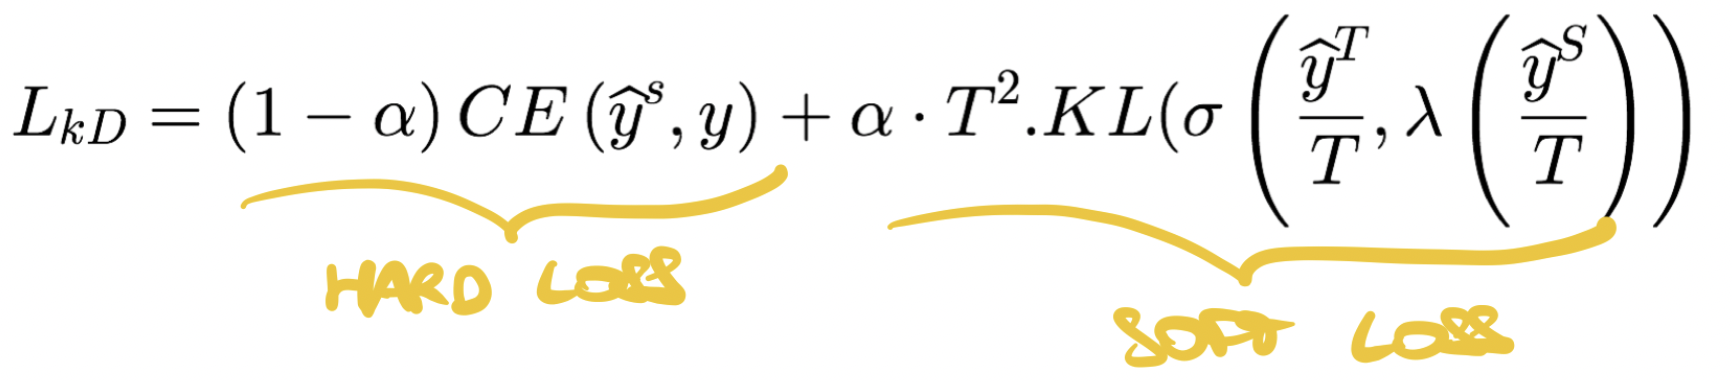

In [ ]:
def KL_Div(student_preds, teacher_preds, T=1.0):
    """ Compute the knowledge-distillation (KD) loss given teacher and student predictions """
    x = F.log_softmax(student_preds/T, dim=1)
    y = F.softmax(teacher_preds/T, dim=1)
    KLDiv = F.kl_div(x,y, reduction='batchmean')
    return KLDiv

def KD_Loss(target_labels, student_preds, teacher_preds, criterion, T=1.0, alpha=0.7):
    student_classification_loss = criterion(student_preds, target_labels)
    teacher_distillation_loss = KL_Div(student_preds, teacher_preds, T)
    KDLoss = (1.0 - alpha) * student_classification_loss + (alpha * T * T) * teacher_distillation_loss
    return KDLoss

*NOTE*
- `alpha` and `Temperature` are hyperparameters in knowledge distillation
- *alpha* value ranges between 0 to 1 where higher values indicate more weightage given to KLD loss compared to loss on groundtruth
- *Temperature* is a softening parameter used to moderate the amount of information from the teacher model.

### Training Loop

In [ ]:
import pandas as pd
from collections import OrderedDict
from knowledge_distillation_content.scripts.modelUtils import plotTrainingResults

def train_validateModel_KD(student_model, criterion, KDLoss, optimizer, dataloader_train, dataloader_valid, device, lr_scheduler, saveModel=False):
    results = []
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move student model to target device
    student_model.to(device)

    print(f"KD parameters = - alpha = {alpha}, temperature = {temperature}")

    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")

        # Training
        student_model.train()
        train_loss = 0.0
        for i, (inputs, labels, teacher_model_preds) in tqdm(enumerate(dataloader_train), total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            teacher_model_preds = teacher_model_preds.to(device)

            # Forward Pass on student model
            student_model_preds = student_model(inputs)
            if(isinstance(student_model_preds, OrderedDict) == True):
              student_model_preds = student_model_preds['out']

            # Return the KD Loss
            loss = KDLoss(labels, student_model_preds, teacher_model_preds, criterion, temperature, alpha)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Adjust the Learning Rate
            lr_scheduler.step()


        # Validate
        student_model.eval()
        validation_loss = 0.0
        iou = meanIoU(device)

        with torch.no_grad():
          for inputs, labels, _ in dataloader_valid:
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_preds = student_model(inputs)
            if(isinstance(y_preds, OrderedDict) == True):
              y_preds = y_preds['out']

            # calculate loss
            loss = criterion(y_preds, labels)
            validation_loss += loss.item()

            # update batch metric information
            iou.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses
        train_loss = train_loss / len(dataloader_train)
        validation_loss = validation_loss / len(dataloader_valid)

        # compute metric
        val_iou = iou.compute()

        print(f'Epoch: {epoch+1}, Train Loss:{train_loss:6.5f}, Validation Loss:{validation_loss:6.5f}, "Mean IOU:",{val_iou: 4.2f}%')

        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 'validationLoss': validation_loss, "Mean IOU": val_iou})

        # if validation loss has decreased and user wants to
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            #if saveModel == True:
                #torch.save(student_model.state_dict(), "temp_KD_student.pt")

    results = pd.DataFrame(results)
    plotTrainingResults(results, "temp_KD_student")
    return results

We'll use the same hyperparameters used for training the plain student model.


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# training hyperparameters
N_EPOCHS = 5
MAX_LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index = 255)

# knowledge distillation hyperparameters
alpha = 0.7
temperature = 1.0

# create model, optimizer, lr_scheduler and pass to training function
kd_student_model = deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=NUM_CLASSES).to(gpu_device)
optimizer = optim.Adam(kd_student_model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validateModel_KD(kd_student_model, criterion, KD_Loss, optimizer, train_dataloader, val_dataloader,
                         gpu_device, lr_scheduler = scheduler)

- We couldn't train on the entire dataset due to Colab's size constraints.
- But we have a trained a model on the entire training set for 12 epochs using the exact procedure as above
- Lets load that model and evaluate its performance and inference metric

In [ ]:
# load pretrained model and transfer to target Device
kd_student_model = deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=NUM_CLASSES).to(gpu_device)
kd_student_model.eval();
kd_student_model.load_state_dict(torch.load('knowledge_distillation_content/weightFiles/kd_deeplabv3_mobilenetv3.pt', map_location=gpu_device))

# evaluate performance on Test set
iou_kd_student = evaluteOnTestData(kd_student_model, None, gpu_device, test_dataloader, meanIoU,
                                    'meanIoU', 'kd_student_mobilenetv3')
print(f"\nkd_student_model has {round(iou_kd_student,3)} IoU metric on test data")

# Visualize output predictions
visualizePredictions(kd_student_model, test_set, gpu_device, 1)

## 5. Results
Now, let's analyze our results and see which model is the best choice.


In [ ]:
torch.set_num_threads(1)

_ = modelMetrics(teacher_model, modelName= 'Teacher',
                 input=torch.rand(1,3,256,256).to(cpu_device), device=cpu_device, verbose=True)
print("IOU Teacher:" ,round(iou_teacher,3))


_ = modelMetrics(student_model, modelName= 'Student (Before KD)',
             input=torch.rand(1,3,256,256).to(cpu_device), device=cpu_device, verbose=True)
print("IOU Student", round(iou_student,3))

_ = modelMetrics(kd_student_model, modelName= 'KD Student',
             input=torch.rand(1,3,256,256).to(cpu_device), device=cpu_device, verbose=True)
print("IOU KD Student", round(iou_kd_student,3))

### Student vs Teacher
* **IOU** of student is **22% worse** than teacher
* **Inference time** of student is **12x faster** than teacher

### KD Student vs Teacher
* **IOU** of KD Student is **13% worse** than teacher
* **Inference time** is **12x faster** than teacher

### KD Student vs Student
*   **IOU** is **8% better** than student.
*   **Inference Time** is **similar**

# Run on a  Video

In [ ]:
def getModelPredInfo(model : nn.Module, input: torch.Tensor, device: torch.device):
    start_time = time.time()
    preds = model(input)
    end_time = time.time()

    if(isinstance(preds, OrderedDict) == True):
      preds = preds['out']

    # calculate model inference time in terms of FPS
    inference_time = end_time - start_time
    FPS = (1.0 / inference_time)
    return preds, FPS

In [ ]:
# read input images from demoVideo sequenqce
image_files = sorted(os.listdir('knowledge_distillation_content/semSeg_256_512/demoVideo/'))
print(f'There are {len(image_files)} images in demoVideo sequence')

# text font and placeholder
frame = np.ones((50, 516, 3), np.uint8) * 255

# utility function to add frame on top of image
def caption_image(image, title, pos, color = (49,49,49)):
    bordered_image = cv2.copyMakeBorder(image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(0,0,0))
    image_with_frame = cv2.vconcat((frame, bordered_image))
    cv2.putText(image_with_frame, title, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)
    return image_with_frame

In [ ]:
import time

TARGET_DEVICE = cpu_device

torch.set_num_threads(1)

# set models to inference mode
teacher_model.eval();
teacher_model.to(TARGET_DEVICE)
kd_student_model.eval();
kd_student_model.to(TARGET_DEVICE)

# we'll get video of 80 images for time constraints
num_video_images = len(image_files)
result_video = []

# iterate through images
for img_path in tqdm(image_files[0:num_video_images]):
    rgb_image = cv2.cvtColor(cv2.imread(f'knowledge_distillation_content/semSeg_256_512/demoVideo/{img_path}'), cv2.COLOR_BGR2RGB)
    torch_image = transform(rgb_image).unsqueeze(0).to(TARGET_DEVICE)

    # get model predictions, FPS
    teacher_model_preds, teacher_model_fps = getModelPredInfo(teacher_model, torch_image, TARGET_DEVICE)
    kd_student_model_preds, kd_student_model_fps = getModelPredInfo(kd_student_model, torch_image, TARGET_DEVICE)
    fps_improvement_percent = int(((kd_student_model_fps / teacher_model_fps) - 1) * 100)

    # get class predictions, convert to color map
    teacher_color_preds = decodeTarget(np.argmax(teacher_model_preds.detach().cpu().numpy(), axis=1)[0]).astype(np.uint8)
    kd_student_color_preds = decodeTarget(np.argmax(kd_student_model_preds.detach().cpu().numpy(), axis=1)[0]).astype(np.uint8)


    captioned_rgb_image = caption_image(rgb_image, 'RGB IMAGE', (200,35));

    captioned_teacher_preds = caption_image(teacher_color_preds, 'TEACHER MODEL', (150,35))

    captioned_student_preds = caption_image(kd_student_color_preds, 'STUDENT MODEL', (70,35))
    cv2.putText(captioned_student_preds, f'{fps_improvement_percent}% faster', (300, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (53,91,156), 2, cv2.LINE_AA);

    total_frame = cv2.vconcat((cv2.cvtColor(captioned_rgb_image, cv2.COLOR_RGB2BGR),
                           cv2.cvtColor(captioned_teacher_preds, cv2.COLOR_RGB2BGR),
                           cv2.cvtColor(captioned_student_preds, cv2.COLOR_RGB2BGR)))

    result_video.append(total_frame)


# video writing object
out = cv2.VideoWriter('knowledge_distillation_output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, \
                      (total_frame.shape[1], total_frame.shape[0]))

for img in result_video:
  out.write(img)
out.release()

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('knowledge_distillation_output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

##### Going Further
The student model can match and even be better than the teacher model through combination of following factors:

  - Train longer
  - Tuning hyperparameters T (temperature) and weight alpha
  - Different loss function (eg: rmse between softmax predictions of teacher and student model predictions)
  - Matching intermediate layers of the student and teacher model
  - Data Augumentation (this can improve test set performance of both the teacher and the student model)
